Tutorial 8: We show in this tutorial how to use MrBeam and DoG-HiT to do polarimetry. To do polarized imaging, we first do Stokes I imaging: let us repeat the steps from tutorial 7.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt

from imagingbase.ehtim_calibration import Calibrator
from imagingbase.minimization_handler import MinimizationHandler
from imagingbase.polimaging import PolHandler
from imagingbase.ehtim_wrapper_pol import EhtimWrapperPol
from imagingbase.solvers.scipy_solver import Minimize

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.6 



In [2]:
#-------------------------------------------------------------------------------
# Synthetic observation
#-------------------------------------------------------------------------------

# Load the image and the array
im = eh.image.load_txt(r'/homes/hmueller/eht-imaging-main/models/avery_sgra_eofn.txt')
obs = eh.obsdata.load_uvfits(r'../synthetic_data/sgra_eht2017.uvfits')

Loading text image:  /homes/hmueller/eht-imaging-main/models/avery_sgra_eofn.txt
Loading uvfits:  ../synthetic_data/sgra_eht2017.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


In [3]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = im.total_flux()                 # Total compact flux density (Jy)
npix      = 64                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 200.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities
                                                               
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-8                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['AA', 'AP']    # baseline to measure zero-spacing flux
rescaling = 0.0035              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 25*10**9]       #cbar-lims for interactive plotting (brightness temperature)

In [4]:
#-------------------------------------------------------------------------------
# Prepare the data
#-------------------------------------------------------------------------------
cal = Calibrator(obs, zero_baseline, zbl, uv_zblcut, 0, sys_noise)
cal.prepare_data()

#-------------------------------------------------------------------------------
# Pre-calibrate the data
#-------------------------------------------------------------------------------

res    = cal.obs.res()  # The nominal array resolution: 1/(longest baseline)

# Make a Gaussian prior image for maximum entropy regularization
# This Gaussian is also the initial image
gaussprior = eh.image.make_square(cal.obs, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# To avoid gradient singularities in the first step, add an additional small Gaussians
gaussprior = gaussprior.add_gauss(zbl*1e-3, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

cal.precalibrate_data()

obs_sc = cal.obs_sc

In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = 20*eh.RADPERUAS

#threshold for identifying gaps in uv-coverage
threshold = 0.15*10**9
#add short baselines wavelets 
short_bl_wl=[20, 23.7]
#add long baseline wavelets
long_bl_wl=[]

#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, gaussprior, zbl, rescaling, data_term, cbar_lims, threshold, short_bl_wl, long_bl_wl, md=True, bessel=True, ellipticities=4) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...


Round 1: Find initial guess ...
Initializing imager data products . . .
U-V flagged 139/1423 visibilities
U-V flagged 1284/1423 visibilities
Imager run 1 
Imaging . . .
time: 12.698014 s
J: 17.474379
chi2_amp : 36.45 chi2_cphase : 5.69 chi2_logcamp : 6.63 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 12.237896 s
J: 5.224444
chi2_amp : 18.34 chi2_cphase : 1.77 chi2_logcamp : 1.96 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 12.462185 s
J: 2.696805
chi2_amp : 13.01 chi2_cphase : 1.01 chi2_logcamp : 1.28 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 13.593195 s
J: 1.500965
chi2_amp : 10.37 chi2_cphase : 0.76 chi2_logcamp : 0.85 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 12.622858 s
J: 0.839723
chi2_amp : 9.03 chi2_cphase : 0.55 chi2_logcamp : 0.67 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 6 
Imaging . . .
time: 12.241014 s
J: 0.401383
chi2_a

2023-11-03 13:21:49,352 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:21:49,353 INFO Display              :: Penalty--> 65.27517675138137
2023-11-03 13:21:49,986 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:21:49,988 INFO Display              :: Penalty--> 64.47425863817455
2023-11-03 13:21:50,804 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:21:50,806 INFO Display              :: Penalty--> 63.946332539482185
2023-11-03 13:21:51,478 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:21:51,480 INFO Display              :: Penalty--> 63.5192933223969
2023-11-03 13:21:52,171 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:21:52,173 INFO Display              :: Penalty--> 63.26054193137381
2023-11-03 13:21:52,967 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:21:52,969 INFO Display              :: Penalty--> 63.06931441832218
2023-11-03 13:21:53,676 INFO CountIterations      :: iteration = 7 / 25
2023

453.41220121006813
Data Fidelity:  12.168751936560213


2023-11-03 13:22:09,232 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:22:09,243 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:10,018 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:22:10,020 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:10,605 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:22:10,607 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:11,097 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:22:11,099 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:12,028 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:22:12,035 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:13,097 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:22:13,099 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:14,053 INFO CountIterations      :: iteration = 7 / 2

704.6288769486482
Data Fidelity:  10.656068472445787


2023-11-03 13:22:29,740 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:22:29,743 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:30,577 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:22:30,581 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:31,265 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:22:31,267 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:31,922 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:22:31,924 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:32,976 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:22:32,990 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:33,922 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:22:33,924 INFO Display              :: Penalty--> 60.839388144395095
2023-11-03 13:22:34,913 INFO CountIterations      :: iteration = 7 / 2

706.2928470079901
Data Fidelity:  9.626078674463297


2023-11-03 13:22:50,364 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:22:50,366 INFO Display              :: Penalty--> 60.8215181099985
2023-11-03 13:22:51,158 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:22:51,161 INFO Display              :: Penalty--> 60.8215181099985
2023-11-03 13:22:52,063 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:22:52,071 INFO Display              :: Penalty--> 60.8215181099985
2023-11-03 13:22:53,092 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:22:53,100 INFO Display              :: Penalty--> 60.8215181099985
2023-11-03 13:22:54,165 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:22:54,168 INFO Display              :: Penalty--> 60.8215181099985
2023-11-03 13:22:55,017 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:22:55,018 INFO Display              :: Penalty--> 60.8125830928002
2023-11-03 13:22:55,714 INFO CountIterations      :: iteration = 7 / 25
2023-11-03

707.1801171466557
Data Fidelity:  8.821728384822269


2023-11-03 13:23:12,824 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:23:12,827 INFO Display              :: Penalty--> 60.64067254230962
2023-11-03 13:23:14,093 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:23:14,105 INFO Display              :: Penalty--> 60.64067254230962
2023-11-03 13:23:14,917 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:23:14,919 INFO Display              :: Penalty--> 60.631737525111326
2023-11-03 13:23:15,592 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:23:15,595 INFO Display              :: Penalty--> 60.49556704341395
2023-11-03 13:23:16,381 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:23:16,383 INFO Display              :: Penalty--> 60.48663202621565
2023-11-03 13:23:16,979 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:23:16,981 INFO Display              :: Penalty--> 60.48663202621565
2023-11-03 13:23:17,777 INFO CountIterations      :: iteration = 7 / 25
202

708.2353646532617
Data Fidelity:  8.210683979644191


2023-11-03 13:23:34,685 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:23:34,687 INFO Display              :: Penalty--> 60.39079877794801
2023-11-03 13:23:35,353 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:23:35,356 INFO Display              :: Penalty--> 60.39079877794801
2023-11-03 13:23:36,144 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:23:36,153 INFO Display              :: Penalty--> 60.38186376074971
2023-11-03 13:23:36,822 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:23:36,825 INFO Display              :: Penalty--> 60.37292874355141
2023-11-03 13:23:37,301 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:23:37,304 INFO Display              :: Penalty--> 60.36399372635311
2023-11-03 13:23:38,032 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:23:38,034 INFO Display              :: Penalty--> 60.362489407651815
2023-11-03 13:23:38,795 INFO CountIterations      :: iteration = 7 / 25
202

708.502911701519
Data Fidelity:  7.7084590717195125


2023-11-03 13:23:55,657 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:23:55,660 INFO Display              :: Penalty--> 60.141390815065854
2023-11-03 13:23:56,430 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:23:56,433 INFO Display              :: Penalty--> 60.12352078066925
2023-11-03 13:23:57,023 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:23:57,025 INFO Display              :: Penalty--> 60.12352078066925
2023-11-03 13:23:57,671 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:23:57,673 INFO Display              :: Penalty--> 60.11308144476966
2023-11-03 13:23:58,378 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:23:58,380 INFO Display              :: Penalty--> 60.11308144476966
2023-11-03 13:23:59,003 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:23:59,005 INFO Display              :: Penalty--> 60.104146427571365
2023-11-03 13:24:00,049 INFO CountIterations      :: iteration = 7 / 25
20

708.4820810049237
Data Fidelity:  7.3190214837791014


2023-11-03 13:24:17,164 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:24:17,167 INFO Display              :: Penalty--> 59.91334334471578
2023-11-03 13:24:17,971 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:24:17,973 INFO Display              :: Penalty--> 59.90440832751747
2023-11-03 13:24:18,727 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:24:18,729 INFO Display              :: Penalty--> 59.90440832751747
2023-11-03 13:24:19,635 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:24:19,648 INFO Display              :: Penalty--> 59.90440832751747
2023-11-03 13:24:20,659 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:24:20,661 INFO Display              :: Penalty--> 59.895473310319176
2023-11-03 13:24:21,673 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:24:21,676 INFO Display              :: Penalty--> 59.895473310319176
2023-11-03 13:24:22,546 INFO CountIterations      :: iteration = 7 / 25
20

709.4025514947784
Data Fidelity:  6.995849794544803


2023-11-03 13:24:38,595 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:24:38,597 INFO Display              :: Penalty--> 59.67777428085921
2023-11-03 13:24:39,377 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:24:39,379 INFO Display              :: Penalty--> 59.67777428085921
2023-11-03 13:24:40,208 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:24:40,210 INFO Display              :: Penalty--> 59.668839263660914
2023-11-03 13:24:40,996 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:24:40,998 INFO Display              :: Penalty--> 59.66733494495961
2023-11-03 13:24:41,690 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:24:41,693 INFO Display              :: Penalty--> 59.658399927761316
2023-11-03 13:24:42,208 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:24:42,210 INFO Display              :: Penalty--> 59.640529893364715
2023-11-03 13:24:42,826 INFO CountIterations      :: iteration = 7 / 25
2

709.6251499205339
Data Fidelity:  6.711818683194764


2023-11-03 13:24:59,340 INFO CountIterations      :: iteration = 1 / 25
2023-11-03 13:24:59,344 INFO Display              :: Penalty--> 59.43327019980435
2023-11-03 13:25:00,224 INFO CountIterations      :: iteration = 2 / 25
2023-11-03 13:25:00,227 INFO Display              :: Penalty--> 59.42283086390476
2023-11-03 13:25:01,120 INFO CountIterations      :: iteration = 3 / 25
2023-11-03 13:25:01,125 INFO Display              :: Penalty--> 59.42283086390476
2023-11-03 13:25:01,906 INFO CountIterations      :: iteration = 4 / 25
2023-11-03 13:25:01,909 INFO Display              :: Penalty--> 59.42283086390476
2023-11-03 13:25:02,710 INFO CountIterations      :: iteration = 5 / 25
2023-11-03 13:25:02,712 INFO Display              :: Penalty--> 59.42283086390476
2023-11-03 13:25:03,380 INFO CountIterations      :: iteration = 6 / 25
2023-11-03 13:25:03,383 INFO Display              :: Penalty--> 59.42132654520346
2023-11-03 13:25:04,146 INFO CountIterations      :: iteration = 7 / 25
2023

709.9599161260899
Data Fidelity:  6.472357889402734


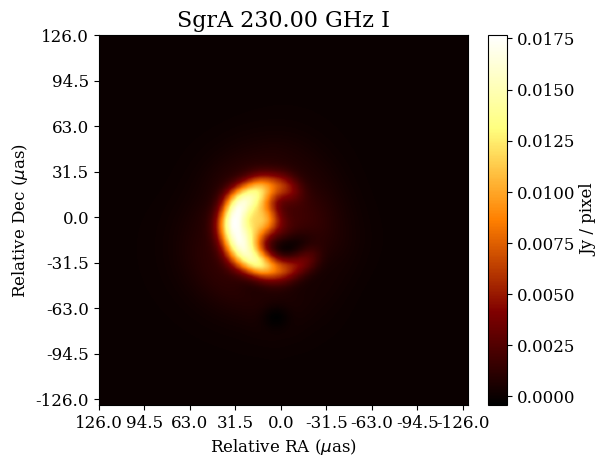

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 109/110 : [----------------------------- ]99%
self_cal time: 27.047927 s


In [6]:
#------------------------------------------------------------------------------
# Run DoG-HiT
#------------------------------------------------------------------------------
alpha=0.5 #wavelet sparsity constraint
tau=1 #stepsize in minimization
img2, wtfcts2, table1, obs_sc = handler.doghit(gaussprior, data_term, cycles=5, last_epochs=False, solution_interval=0, alpha=alpha, tau=tau, maxiter=10, display=False)
img2.display()

obs_sc = eh.selfcal(obs_sc, img2, method='phase', ttype=ttype)
handler.updateobs(obs_sc.copy())

Now we have a Stokes I representation of the image. Recall from tutorial 5 and tutorial 6 that DoG-HiT computes the multiresolution support as a byproduct. We used this information before to refine the Stokes I imaging. Now we use the same prior information (only changing coefficients in the multiresolution support) to do polarized imaging for Q and U.

Similarly to Stokes I imaging, we first define a wrapper object for the polarized quantities. Then we define the minimization handler for polarized quantities. Note that the multiscale dictionary (handler.op), the multiresolution support (handler.mask) are already stored in the handler object. So we just copy over these properties.

In the moment only pol_trans=False and pol_solve=(1,1,1) are supported right now.

In [7]:
wrapper = EhtimWrapperPol(obs_sc, img2.regrid_image(fov, npix+1), img2.regrid_image(fov, npix+1), zbl, d='pvis', clipfloor=-100, pol_solve=(1,1,1), pol_trans=False)
pol = PolHandler(wrapper, handler.mask, handler.op, wtfcts2*rescaling)

Generating I image...
No polarimetric image in the initial image!


Now we are ready to do Stokes Q and U imaging with a gradient descent algorithm. The initial guess and the objective functional and Hilbert Space Setting are allocated by the PolHandler under pol.final_init, pol.final_func and pol.final_setting.

2023-11-03 13:31:14,257 INFO CountIterations      :: iteration = 1 / 1000
2023-11-03 13:31:14,509 INFO Display              :: Data Fidelity--> 2.2802538192250035
2023-11-03 13:31:15,720 INFO CountIterations      :: iteration = 2 / 1000
2023-11-03 13:31:15,990 INFO Display              :: Data Fidelity--> 2.2128598198341347
2023-11-03 13:31:17,010 INFO CountIterations      :: iteration = 3 / 1000
2023-11-03 13:31:17,200 INFO Display              :: Data Fidelity--> 2.1491111710165915
2023-11-03 13:31:18,075 INFO CountIterations      :: iteration = 4 / 1000
2023-11-03 13:31:18,344 INFO Display              :: Data Fidelity--> 2.088778226841919
2023-11-03 13:31:19,169 INFO CountIterations      :: iteration = 5 / 1000
2023-11-03 13:31:19,311 INFO Display              :: Data Fidelity--> 2.031646680228281
2023-11-03 13:31:20,099 INFO CountIterations      :: iteration = 6 / 1000
2023-11-03 13:31:20,357 INFO Display              :: Data Fidelity--> 1.9775165096132405
2023-11-03 13:31:21,079 

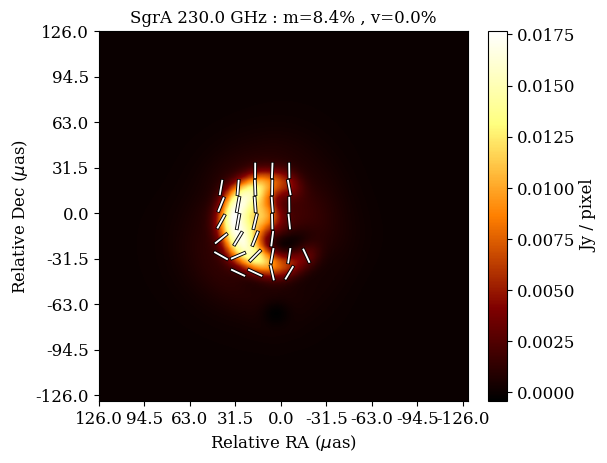

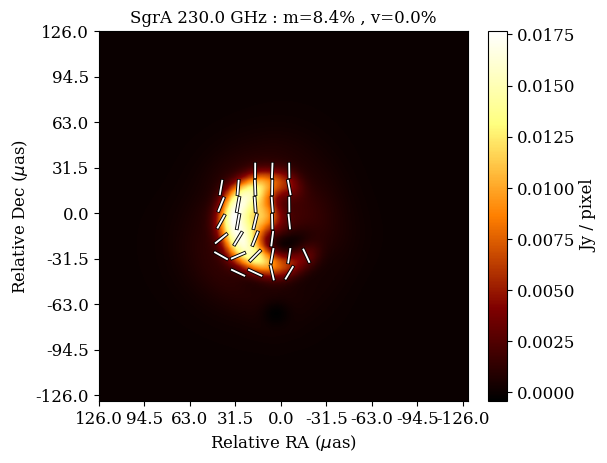

In [8]:
options = {'maxiter':100}

solver = Minimize(pol.final_func, pol.final_init.flatten(), method='L-BFGS-B', options=options)
solver.hess = None

reco = solver.run()
reco2 = pol.final_op(reco)
out = wrapper.formatoutput(reco2)

pol.find_pol_init(out.blur_circ(0,res))

reco = handler.grad_desc(pol.final_init.flatten().copy(), 10**(-6), pol.final_func, pol.final_setting, maxit=1000)
reco2 = pol.final_op(reco)

out = wrapper.formatoutput(reco2)

out.display(plotp=True)

Additionally to doing polarimetry, MrBeam also contains an operator that maps the polarized tuple (I, Q, U) onto the polarized closure trace ([Broderick and Pesce, 2020, ApJ, 904, 2, 126]). These traces are independent of calibration effects, in particular D-terms, but they also contain degeneracies (e.g. rottaion invariance in Poincare sphere). 

The ClosureTracePol class is a fully regpy operator. Hence, there is not only an implementation of the evaluation, but also of the derivative and the adjoint of the derivative. Thus, it is possible to use the closure traces as a calibration independent data fidelity term additionally to the option of using polarized visibilities. However, the minimization is very unstable. 

In [9]:
from imagingbase.operators.pol_trace import ClosureTracePol, build_cltrace_operator

#Let us first create the closure trace operator manually for instructory reasons
from ehtim.imaging.imager_utils import chisqdata_camp
#Get Fourier matrix
_, _, A4 = chisqdata_camp(wrapper.Obsdata, wrapper.Prior, wrapper.embed_mask)
clpol = ClosureTracePol(A4, order='ABCD')
xtuple = wrapper.xtuple
print(clpol(xtuple))

#There are six independent closure trace combinations with four different stations
#We can define a joint data fidelity term on the product space, i.e. the combined chi^2 to the closure traces
#Errors will be computed as part of the process
norm = build_cltrace_operator(wrapper, errors=True)
print(norm(xtuple))

[ 3.58617519e+02+1.69787482e+00j  3.58772885e+02-8.85377386e-01j
 -6.09207735e+01+2.10832533e+01j -9.19156681e-02+8.07479839e-02j
  1.00052967e+00+1.89905595e-03j  3.48337099e+02-3.40328750e+00j
  3.48462772e+02+4.16001381e+00j -5.59828103e+01+2.48627729e+01j
 -8.65835257e-02+8.73241824e-02j  1.00054749e+00+1.90676643e-03j
  3.40767440e+02-7.50410339e+00j  3.40872918e+02+8.21294576e+00j
 -5.17402316e+01+2.79509606e+01j -8.11912958e-02+9.26297172e-02j
  1.00055758e+00+1.91165499e-03j  3.35646273e+02-1.10102369e+01j
  3.35737972e+02+1.16789297e+01j -4.81094328e+01+3.05943440e+01j
 -7.58508764e-02+9.68389905e-02j  1.00056021e+00+1.91461017e-03j
  3.32729744e+02-1.42537597e+01j  3.32811856e+02+1.48892729e+01j
 -4.49652289e+01+3.29972073e+01j -7.05642902e-02+1.00149118e-01j
  1.00055565e+00+1.91657873e-03j  3.31924966e+02-1.74146737e+01j
  3.32000351e+02+1.80241941e+01j -4.22683261e+01+3.52547167e+01j
 -6.54288972e-02+1.02649329e-01j  1.00054411e+00+1.91812268e-03j
  3.33128385e+02-2.067640